## Modeling for predicting 72h ED revisit at ED discharge

Flow:
1. Task-specific filter
2. Variable selection
3. Modeling script
4. Performance output


### Load train and test

In [1]:
import os
import time
import tensorflow as tf
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import optimizers, metrics
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.layers import concatenate
from tensorflow.keras.models import load_model
from helpers_for_tasks import PlotROCCurve, get_lstm_data_gen


output_path = 'D:\\1_Teaching_Work_Folder\\SMU\\MITB_HealthcareAnalytics\\Group_Project\\Uploaded_Git\\output_2023'
path = output_path

df_train = pd.read_csv((os.path.join(path, 'train2.csv')))
df_test = pd.read_csv((os.path.join(path, 'test2.csv')))
confidence_interval = 95
random_seed = 0

In [2]:
pd.set_option('display.max_columns', 100) 
pd.set_option('display.max_rows', 100) 
df_train.head()

,index,subject_id,hadm_id,stay_id,intime,outtime,anchor_age,gender,anchor_year,dod,admittime,dischtime,deathtime,race,edregtime,edouttime,insurance,in_year,age,before_ed_mortality,outcome_hospitalization,outcome_inhospital_mortality,ed_death,ed_los,intime_icu,time_to_icu_transfer,outcome_icu_transfer_12h,outcome_critical,n_ed_30d,n_ed_90d,n_ed_365d,next_ed_visit_time,next_ed_visit_time_diff,outcome_ed_revisit_3d,n_hosp_30d,n_hosp_90d,n_hosp_365d,n_icu_30d,n_icu_90d,n_icu_365d,ed_los_hours,time_to_icu_transfer_hours,next_ed_visit_time_diff_days,triage_temperature,triage_heartrate,triage_resprate,triage_o2sat,triage_sbp,triage_dbp,triage_pain,...,cci_Liver2,cci_Cancer2,cci_HIV,eci_CHF,eci_Arrhythmia,eci_Valvular,eci_PHTN,eci_PVD,eci_HTN1,eci_HTN2,eci_Paralysis,eci_NeuroOther,eci_Pulmonary,eci_DM1,eci_DM2,eci_Hypothyroid,eci_Renal,eci_Liver,eci_PUD,eci_HIV,eci_Lymphoma,eci_Tumor2,eci_Tumor1,eci_Rheumatic,eci_Coagulopathy,eci_Obesity,eci_WeightLoss,eci_FluidsLytes,eci_BloodLoss,eci_Anemia,eci_Alcohol,eci_Drugs,eci_Psychoses,eci_Depression,ed_temperature_last,ed_heartrate_last,ed_resprate_last,ed_o2sat_last,ed_sbp_last,ed_dbp_last,ed_pain_last,n_med,n_medrecon,triage_MAP,score_CCI,score_CART,score_REMS,score_NEWS,score_NEWS2,score_MEWS
0,273532,18971123,21753872.0,37200982,2149-07-15 22:41:00,2149-07-16 06:27:00,45.0,F,2149.0,NaN,2149-07-16 04:10:00,2149-07-28 18:37:00,NaN,WHITE,2149-07-15 22:41:00,2149-07-16 06:27:00,Other,2149,45.0,False,True,False,False,0 days 07:46:00,NaN,NaN,False,False,0,1,1,2149-08-01 14:27:00,16 days 08:00:00,False,0,0,0,0,0,0,7.77,NaN,16.33,37.444444,102.0,19.0,100.0,133.0,88.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,36.333333,72.0,16.0,100.0,165.0,105.0,0.0,3.0,1.0,103.000000,0,0,2,1,1,2
1,253777,15439233,NaN,31867345,2159-12-20 19:43:00,2159-12-20 19:59:00,18.0,M,2159.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2159,18.0,False,False,False,False,0 days 00:16:00,NaN,NaN,False,False,0,0,0,2160-02-11 01:14:00,52 days 05:15:00,False,0,0,0,0,0,0,0.27,NaN,52.22,37.111111,70.0,20.0,99.0,151.0,64.0,7.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,36.666667,60.0,16.0,100.0,132.0,70.0,7.0,1.0,0.0,93.000000,0,0,0,0,0,1
2,365291,15341533,NaN,30037900,2171-09-02 21:24:00,2171-09-02 21:27:00,40.0,F,2171.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2171,40.0,False,False,False,False,0 days 00:03:00,NaN,NaN,False,False,0,0,0,NaN,NaN,False,0,0,0,0,0,0,0.05,NaN,NaN,37.555556,97.0,16.0,97.0,120.0,70.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,37.555556,95.0,18.0,98.0,113.0,67.0,0.0,0.0,0.0,86.666667,0,0,0,1,1,1
3,76261,13512582,NaN,38777853,2131-11-08 22:59:00,2131-11-08 23:04:00,70.0,F,2131.0,NaN,NaN,NaN,NaN,HISPANIC/LATINO - PUERTO RICAN,NaN,NaN,NaN,2131,70.0,False,False,False,False,0 days 00:05:00,NaN,NaN,False,False,0,0,0,2137-11-14 18:47:00,2197 days 19:43:00,False,0,0,0,0,0,0,0.08,NaN,2197.82,37.000000,58.0,16.0,100.0,155.0,44.0,10.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,37.111111,51.0,18.0,96.0,173.0,63.0,2.0,3.0,2.0,81.000000,3,13,7,0,0,1
4,99718,17758321,NaN,35942414,2115-06-25 13:15:00,2115-06-25 13:38:00,50.0,M,2115.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2115,50.0,False,False,False,False,0 days 00:23:00,NaN,NaN,False,False,1,1,1,NaN,NaN,False,0,0,0,0,0,0,0.38,NaN,NaN,36.555556,72.0,16.0,96.0,187.0,108.0,6.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,36.777778,62.0,16.0,100.0,161.0,99.0,0.0,1.0,2.0,134.333333,1,0,5,0,0,1


### 1. task-specific filter: exclude ED death cases for train and test

In [3]:
df_train = df_train[(df_train['before_ed_mortality'] == False) & (df_train['outcome_hospitalization'] == False) & (df_train['ed_death'] == False)]
df_test = df_test[(df_test['before_ed_mortality'] == False) & (df_test['outcome_hospitalization'] == False) & (df_test['ed_death'] == False)].reset_index()

### 2. Variable Selection

In [4]:
variable = ["age", "gender", 
            
            "n_ed_30d", "n_ed_90d", "n_ed_365d", "n_hosp_30d", "n_hosp_90d", 
            "n_hosp_365d", "n_icu_30d", "n_icu_90d", "n_icu_365d", 
            
            "triage_pain", "triage_acuity",
            
            "chiefcom_chest_pain", "chiefcom_abdominal_pain", "chiefcom_headache", 
            "chiefcom_shortness_of_breath", "chiefcom_back_pain", "chiefcom_cough", 
            "chiefcom_nausea_vomiting", "chiefcom_fever_chills", "chiefcom_syncope",
            "chiefcom_dizziness",
            
            "cci_MI", "cci_CHF", "cci_PVD", "cci_Stroke", "cci_Dementia", "cci_Pulmonary", 
            "cci_Rheumatic", "cci_PUD", "cci_Liver1", "cci_DM1", "cci_DM2", 
            "cci_Paralysis", "cci_Renal", "cci_Cancer1", "cci_Liver2", "cci_Cancer2", 
            "cci_HIV",
            
            "eci_Arrhythmia", "eci_Valvular", "eci_PHTN",  "eci_HTN1", "eci_HTN2",  
            "eci_NeuroOther", "eci_Hypothyroid", "eci_Lymphoma", "eci_Coagulopathy", 
            "eci_Obesity", "eci_WeightLoss", "eci_FluidsLytes", "eci_BloodLoss", 
            "eci_Anemia", "eci_Alcohol", "eci_Drugs", "eci_Psychoses", "eci_Depression",
            
            "ed_temperature_last", "ed_heartrate_last", "ed_resprate_last", 
            "ed_o2sat_last", "ed_sbp_last", "ed_dbp_last", "ed_los", "n_med", "n_medrecon"]

outcome = "outcome_ed_revisit_3d"

In [5]:
X_train = df_train[variable].copy()
y_train = df_train[outcome].copy()
X_test = df_test[variable].copy()
y_test = df_test[outcome].copy()

In [6]:
X_train.dtypes.to_frame().T

,age,gender,n_ed_30d,n_ed_90d,n_ed_365d,n_hosp_30d,n_hosp_90d,n_hosp_365d,n_icu_30d,n_icu_90d,n_icu_365d,triage_pain,triage_acuity,chiefcom_chest_pain,chiefcom_abdominal_pain,chiefcom_headache,chiefcom_shortness_of_breath,chiefcom_back_pain,chiefcom_cough,chiefcom_nausea_vomiting,chiefcom_fever_chills,chiefcom_syncope,chiefcom_dizziness,cci_MI,cci_CHF,cci_PVD,cci_Stroke,cci_Dementia,cci_Pulmonary,cci_Rheumatic,cci_PUD,cci_Liver1,cci_DM1,cci_DM2,cci_Paralysis,cci_Renal,cci_Cancer1,cci_Liver2,cci_Cancer2,cci_HIV,eci_Arrhythmia,eci_Valvular,eci_PHTN,eci_HTN1,eci_HTN2,eci_NeuroOther,eci_Hypothyroid,eci_Lymphoma,eci_Coagulopathy,eci_Obesity,eci_WeightLoss,eci_FluidsLytes,eci_BloodLoss,eci_Anemia,eci_Alcohol,eci_Drugs,eci_Psychoses,eci_Depression,ed_temperature_last,ed_heartrate_last,ed_resprate_last,ed_o2sat_last,ed_sbp_last,ed_dbp_last,ed_los,n_med,n_medrecon
0,float64,object,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,object,float64,float64


In [7]:
encoder = LabelEncoder()
X_train['gender'] = encoder.fit_transform(X_train['gender'])
X_test['gender'] = encoder.transform(X_test['gender'])

In [8]:
X_train['ed_los'] = pd.to_timedelta(X_train['ed_los']).dt.seconds / 60
X_test['ed_los'] = pd.to_timedelta(X_test['ed_los']).dt.seconds / 60

In [9]:
print('class ratio')
ratio = y_train.sum()/(~y_train).sum()
print('positive : negative =', ratio, ': 1')

class ratio
positive : negative = 0.04750162232316677 : 1


### 3.  Modeling script

In [10]:
# Containers for all results
result_list = []

Logistic Regression:


c:\Users\Sean Lam\.conda\envs\snowflakes\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training time: 2.7955522537231445 seconds
AUC: 0.6924634443898664
AUPRC: 0.16051504618367146
Sensitivity: 0.629472693032015
Specificity: 0.6438905665479786
Score thresold: 0.04075126404041426
2.5 97.5


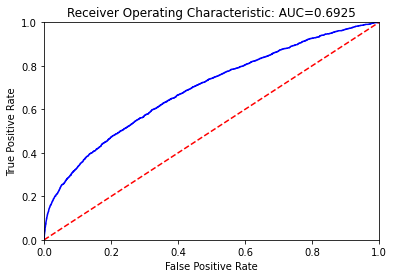

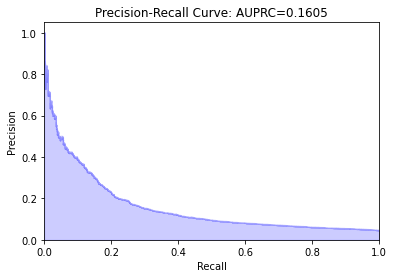

In [11]:
print("Logistic Regression:")
from sklearn.linear_model import LogisticRegression
logreg=LogisticRegression()
start = time.time()
logreg.fit(X_train,y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = logreg.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval, random_seed=random_seed)

results = ["LR"]
results.extend(result)
results.append(runtime)
result_list.append(results)



RandomForest:
Training time: 36.797757387161255 seconds
AUC: 0.6708652122512487
AUPRC: 0.1507361803819023
Sensitivity: 0.617231638418079
Specificity: 0.6187632397349799
Score thresold: 0.05
2.5 97.5


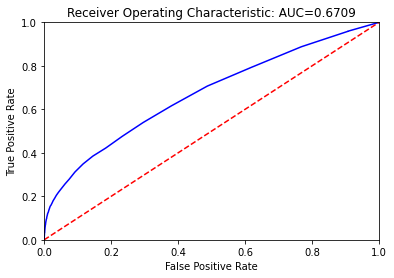

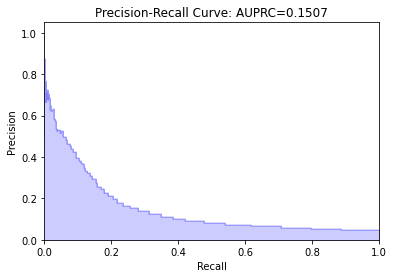

[0.08376251 0.01452496 0.02087076 0.02482972 0.03441804 0.00923877
 0.01245217 0.02089055 0.00107163 0.00221679 0.00414999 0.04214972
 0.02195955 0.00551053 0.00879978 0.00585265 0.00029274 0.00558204
 0.00259844 0.00426429 0.00298657 0.00172207 0.00324192 0.00283827
 0.00289121 0.00255078 0.00304697 0.00116379 0.00595626 0.00194504
 0.00172115 0.00400876 0.00518699 0.00281907 0.00143908 0.00265011
 0.00342155 0.00158324 0.00166436 0.00163521 0.00521301 0.0022904
 0.00224183 0.0027799  0.00649589 0.0044499  0.00388405 0.0010871
 0.00333773 0.00473434 0.00299314 0.0053876  0.00138732 0.00355929
 0.00521791 0.00499941 0.00327954 0.00611989 0.06687629 0.07678926
 0.03751433 0.03897657 0.07977007 0.07694484 0.08364035 0.03843654
 0.05168547]


In [12]:
print("RandomForest:")
from sklearn.ensemble import RandomForestClassifier
rf= RandomForestClassifier()
start = time.time()
rf.fit(X_train,y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = rf.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval, random_seed=random_seed)
importances = rf.feature_importances_
print(importances)

results = ["RF"]
results.extend(result)
results.append(runtime)
result_list.append(results)

GradientBoosting:
Training time: 38.57637071609497 seconds
AUC: 0.7040853131450637
AUPRC: 0.16718918330870652
Sensitivity: 0.6214689265536724
Specificity: 0.6645107495380178
Score thresold: 0.03914934112242799
2.5 97.5


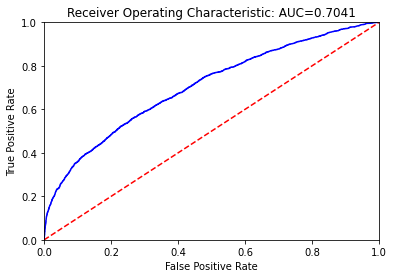

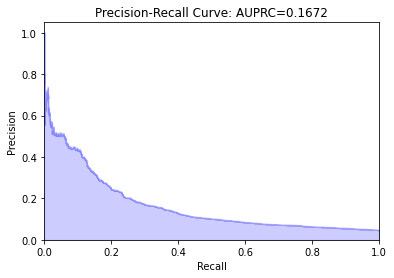

In [13]:
print("GradientBoosting:")
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier()
start = time.time()
gb.fit(X_train, y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = gb.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval, random_seed=random_seed)

results = ["GB"]
results.extend(result)
results.append(runtime)
result_list.append(results)

In [14]:
class MLP(tf.keras.Model):
    def __init__(self):
        super(MLP, self).__init__()
        self.dense_1 = Dense(128, activation='relu')
        self.dense_2 = Dense(64, activation='relu')
        self.classifier = Dense(1, activation='sigmoid')

    def call(self, x):
        x = self.dense_1(x)
        x = self.dense_2(x)
        return self.classifier(x)

In [15]:
# skip this cell if not retraining
mlp = MLP()
mlp.compile(loss='binary_crossentropy', 
              optimizer=optimizers.Adam(learning_rate=0.001), 
              metrics=['accuracy', 'AUC', {'auprc': metrics.AUC(name='auprc', curve='PR')}, 
                       'TruePositives', 'TrueNegatives', 'Precision', 'Recall'])
start = time.time()
mlp.fit(X_train.astype(np.float32), y_train, batch_size=200, epochs=20)
runtime = time.time() - start
print('Training time:', runtime, 'seconds')
mlp.save('72h_ed_revisit_mlp')

Epoch 1/20
929/929 [==============================] - 1s 930us/step - loss: 0.1897 - accuracy: 0.9540 - auc: 0.6077 - auprc: 0.1124 - true_positives: 383.0000 - true_negatives: 176703.0000 - precision: 0.4279 - recall: 0.0455
Epoch 2/20
929/929 [==============================] - 1s 958us/step - loss: 0.1818 - accuracy: 0.9543 - auc: 0.6284 - auprc: 0.1246 - true_positives: 364.0000 - true_negatives: 176777.0000 - precision: 0.4539 - recall: 0.0432
Epoch 3/20
929/929 [==============================] - 1s 917us/step - loss: 0.1773 - accuracy: 0.9547 - auc: 0.6407 - auprc: 0.1346 - true_positives: 360.0000 - true_negatives: 176863.0000 - precision: 0.5056 - recall: 0.0428
Epoch 4/20
929/929 [==============================] - 1s 912us/step - loss: 0.1753 - accuracy: 0.9547 - auc: 0.6536 - auprc: 0.1390 - true_positives: 316.0000 - true_negatives: 176899.0000 - precision: 0.5000 - recall: 0.0375
Epoch 5/20
929/929 [==============================] - 1s 949us/step - loss: 0.1736 - accuracy: 0

MLP:
AUC: 0.7012610061099385
AUPRC: 0.16666405236267695
Sensitivity: 0.6435969868173258
Specificity: 0.6481047460224456
Score thresold: 0.04937789
2.5 97.5


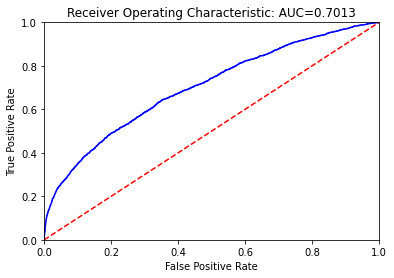

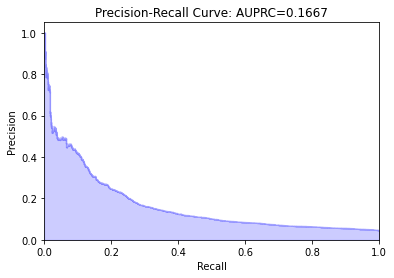

In [16]:
print("MLP:")
#mlp = load_model('72h_ed_revisit_mlp')
probs = mlp.predict(X_test.astype(np.float32))
result = PlotROCCurve(probs,y_test, ci=confidence_interval, random_seed=random_seed)
results = ["MLP"]
results.extend(result)
results.append(runtime)
result_list.append(results)

### 4. Performance output

In [17]:
#result_df = pd.read_csv(os.path.join(path, 'result_72h_ed_revivist_disposition.csv'))
result_df = pd.DataFrame(result_list, columns=['Model', 'auroc', 'ap', 'sensitivity', 'specificity', 'threshold', 'lower_auroc', 'upper_auroc', 'std_auroc', 'lower_ap', 'upper_ap', 'std_ap', 'lower_sensitivity', 'upper_sensitivity', 'std_sensitivity', 'lower_specificity', 'upper_specificity', 'std_specificity', 'runtime'])
result_df.to_csv(os.path.join(path, 'result_72h_ed_revivist_disposition.csv'), index=False)
result_df = result_df.round(3)
formatted_result_df = pd.DataFrame()
formatted_result_df[['Model', 'Threshold']] = result_df[['Model', 'threshold']]
formatted_result_df['AUROC'] = result_df['auroc'].astype(str) + ' (' + result_df['lower_auroc'].astype(str) + \
                               '-' + result_df['upper_auroc'].astype(str) + ')'
formatted_result_df['AUPRC'] = result_df['ap'].astype(str) + ' (' + result_df['lower_ap'].astype(str) + \
                               '-' + result_df['upper_ap'].astype(str) + ')'
formatted_result_df['Sensitivity'] = result_df['sensitivity'].astype(str) + ' (' + result_df['lower_sensitivity'].astype(str) + \
                                     '-' + result_df['upper_sensitivity'].astype(str) + ')'
formatted_result_df['Specificity'] = result_df['specificity'].astype(str) + ' (' + result_df['lower_specificity'].astype(str) + \
                                     '-' + result_df['upper_specificity'].astype(str) + ')'
formatted_result_df[['Runtime']] = result_df[['runtime']]
formatted_result_df.to_csv(os.path.join(path, 'task3.csv'), index=False)
formatted_result_df

,Model,Threshold,AUROC,AUPRC,Sensitivity,Specificity,Runtime
0,LR,0.041,0.692 (0.68-0.704),0.161 (0.148-0.177),0.629 (0.592-0.66),0.644 (0.628-0.681),2.796
1,RF,0.050,0.671 (0.659-0.686),0.151 (0.142-0.167),0.617 (0.566-0.637),0.619 (0.615-0.703),36.798
2,GB,0.039,0.704 (0.695-0.717),0.167 (0.156-0.181),0.621 (0.594-0.65),0.665 (0.646-0.702),38.576
3,MLP,0.049,0.701 (0.69-0.714),0.167 (0.157-0.181),0.644 (0.626-0.662),0.648 (0.643-0.665),18.656


In [18]:
importance_df = pd.DataFrame(zip(variable, importances), columns=['Variable','Importance'])
importance_df.to_csv(os.path.join(path, 'importances_72h_ed_revisit_disposition.csv'))
importance_df.sort_values(by='Importance', axis=0,ascending=False)

,Variable,Importance
0,age,0.083763
64,ed_los,0.083640
62,ed_sbp_last,0.079770
63,ed_dbp_last,0.076945
59,ed_heartrate_last,0.076789
58,ed_temperature_last,0.066876
66,n_medrecon,0.051685
11,triage_pain,0.042150
61,ed_o2sat_last,0.038977
65,n_med,0.038437
